In [1]:
import numpy as np
import scipy.interpolate as interp
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

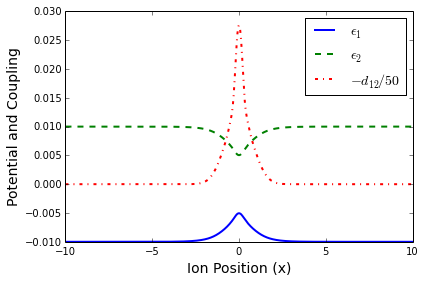

In [2]:
# load data
xgrid_data,e1_data = np.loadtxt("Tully-model1-e1.dat").T
xgrid_data,e2_data = np.loadtxt("Tully-model1-e2.dat").T
xgrid_data,d12_data = np.loadtxt("Tully-model1-d12.dat").T

# interpolate
e1fit  = interp.splrep(xgrid_data,e1_data)
e2fit  = interp.splrep(xgrid_data,e2_data)
d12fit = interp.splrep(xgrid_data,d12_data)

e1 = lambda x: interp.splev(x,e1fit)
e2 = lambda x: interp.splev(x,e2fit)
d12 = lambda x: interp.splev(x,d12fit)

# check splines
pos_min = -10.0
pos_max = 10.0

xfine = np.linspace(-10,10,1000)

fig = plt.figure()
ax  = fig.add_subplot(111)
ax.set_xlabel("Ion Position (x)",fontsize=14)
ax.set_ylabel("Potential and Coupling",fontsize=14)

ax.plot(xfine,e1(xfine),"-",lw=2,label="$\epsilon_1$")
ax.plot(xfine,e2(xfine),"--",lw=2,label="$\epsilon_2$")
ax.plot(xfine,-d12(xfine)/50.,"-.",lw=2,label="$-d_{12}/50$")

ax.legend(fontsize=14,loc="upper right")
fig.tight_layout()
#plt.savefig("single.eps")

In [3]:
# calculate forces on surfaces
e1der = lambda x: interp.splev(x, interp.splder(e1fit,1) )
e2der = lambda x: interp.splev(x, interp.splder(e2fit,1) )

In [4]:
def run1(x0,v0,c1,nstep,dt=0.1,m=2000.):

    hbar = 1.0
    
    # initialize electronic state
    c2 = np.sqrt(1.-c1*c1)
    a11 = c1*np.conj(c1)
    a12 = c1*np.conj(c2)
    a21 = np.conj(a12)
    a22 = c2*np.conj(c2)

    # initialize ion
    pos = x0
    vel = v0

    # make room for scalar quantities
    pos_trace = np.zeros(nstep)
    vel_trace = np.zeros(nstep)
    a11_trace  = np.zeros(nstep)
    a22_trace  = np.zeros(nstep)
    energy_trace = np.zeros(nstep)
    pot_trace = np.zeros(nstep)
    prob_trace = np.zeros(nstep)

    on_surface1 = False
    surface = e2
    surface_der = e2der
    switch_prob = 0.0

    for t in range(nstep):

        # record scalar quantities
        pos_trace[t] = pos
        vel_trace[t] = vel
        pot_trace[t] = surface(pos)
        energy_trace[t] = 0.5*m*vel*vel + surface(pos)
        
        a11_trace[t] = a11.real
        a22_trace[t] = a22.real
        prob_trace[t] = switch_prob.real

        # propagate electronic state forward
        c1 += dt*(c1*e1(pos)/(1j*hbar) - c2*vel*d12(pos))
        c2 += dt*(c2*e2(pos)/(1j*hbar) + c1*vel*d12(pos))

        # find new electronic state and change rate
        a11 = c1*np.conj(c1)
        a12 = c1*np.conj(c2)
        a21 = np.conj(a12)
        a22 = c2*np.conj(c2)

        b12 = -2.*(np.conj(a12)*vel*d12(pos)).real
        b21 =  2.*(np.conj(a21)*vel*d12(pos)).real
        
        # calculate hop probability
        if on_surface1:
            switch_prob = dt*b21/a11
        else:
            switch_prob = dt*b12/a22
        # end if

        # decide hopping
        hopped = False
        if switch_prob.real > np.random.rand():
            
            new_kinetic = 0.0
            # check kinetic energy
            cur_energy = energy_trace[t]
            if on_surface1:
                new_kinetic = cur_energy - e2(pos)
            else:
                new_kinetic = cur_energy - e1(pos)
            # end if

            if new_kinetic < 0:
                hopped = False
            else:
                pass#hopped = True
            # end if

            # switch surface if decide to hop
            if hopped:

                if on_surface1:
                    surface = e2
                    surface_der = e2der
                else:
                    surface = e1
                    surface_der = e1der
                # end if
                on_surface1 = not on_surface1

                # adjust velocity
                vel = np.sign(vel) * np.sqrt(2.*new_kinetic/m)

            # end if hopped

        # end if switch_prob > rand()

        # propagate ion forward
        a0 = -surface_der(pos)/m
        pos += vel*dt + 0.5*a0*dt*dt
        a1 = -surface_der(pos)/m
        vel += 0.5*(a0+a1)*dt
        
        if pos >= pos_max or pos <= pos_min:
            break
        # end if

    # end for t
    
    transmission = False
    reflection   = False
    if (pos >= pos_max):
        transmission = True
    # end if
    elif (pos <= pos_min):
        reflection = True
    # end if
    
    return pos_trace[:t],vel_trace[:t],pot_trace[:t],energy_trace[:t]\
,a11_trace[:t],a22_trace[:t],t\
,on_surface1,transmission,reflection,prob_trace[:t]
# end def 

In [81]:
dt = 5.0
nstep = 10000
ptrace,vtrace,pot_trace,energy_trace,a11_trace,a22_trace,t\
,on1,trans,ref,prob_trace = run1(-3.0,0.3/2000.,1.0,nstep,dt)

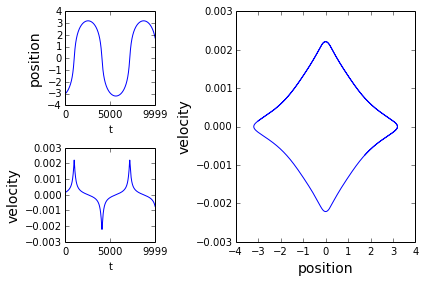

In [103]:
gs = gridspec.GridSpec(2, 2,
        width_ratios=[1,2],
        height_ratios=[1,1]
    )
fig = plt.figure()

time = np.linspace(0,t,nstep-1)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[:,1])

ax1.plot(time,ptrace)
ax1.set_xticks(np.linspace(min(time),max(time),3))
ax1.set_xlabel("t")
ax1.set_ylabel("position",fontsize=14)

ax2.plot(vtrace)
ax2.set_xticks(np.linspace(min(time),max(time),3))
ax2.set_xlabel("t")
ax2.set_ylabel("velocity",fontsize=14)

ax3.plot(ptrace,vtrace)
ax3.set_xlabel("position",fontsize=14)
ax3.set_ylabel("velocity",fontsize=14)

fig.tight_layout()
plt.savefig("model-1-bomd.eps")

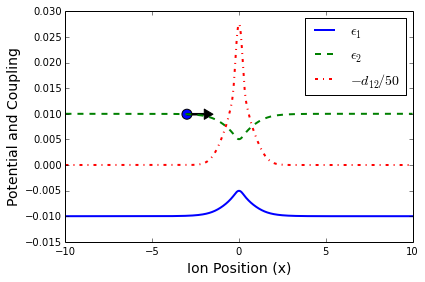

In [239]:
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.set_xlabel("Ion Position (x)",fontsize=14)
ax.set_ylabel("Potential and Coupling",fontsize=14)

ax.plot(xfine,e1(xfine),"-",lw=2,label="$\epsilon_1$")
ax.plot(xfine,e2(xfine),"--",lw=2,label="$\epsilon_2$")
ax.plot(xfine,-d12(xfine)/50.,"-.",lw=2,label="$-d_{12}/50$")
ax.scatter(-3,e2(-3),s=100)
ax.arrow(-3,e2(-3),1,0,head_width=0.002,head_length=0.5,
         color="black",width=0.0003)
ax.set_xlim(-10,10)

ax.legend(fontsize=14,loc="upper right")
fig.tight_layout()
#plt.savefig("model-1-boinit.eps")

In [195]:
dt = 0.5
nstep = 3500
ptrace,vtrace,pot_trace,energy_trace,a11_trace,a22_trace,t\
,on1,trans,ref,prob_trace = run1(-0.665,0.3/2000.,0.6,nstep,dt)

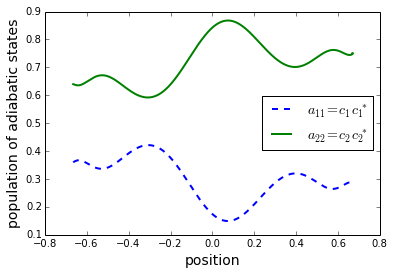

In [209]:
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.set_xlabel("position",fontsize=14)
ax.set_ylabel("population of adiabatic states",fontsize=14)

ax.plot(ptrace,a11_trace,label="$a_{11}=c_1c_1^*$",ls="--",lw=2)
ax.plot(ptrace,a22_trace,label="$a_{22}=c_2c_2^*$",lw=2)

ax.legend(loc="right",fontsize=14)
#plt.savefig("model-1-cpm.eps")

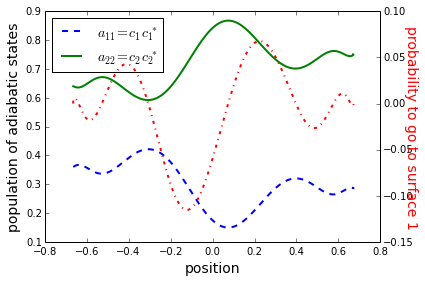

In [236]:
fig = plt.figure()

ax  = fig.add_subplot(111)
ax.set_xlabel("position",fontsize=14)
ax.set_ylabel("population of adiabatic states",fontsize=14)

ax.plot(ptrace,a11_trace,label="$a_{11}=c_1c_1^*$",ls="--",lw=2)
ax.plot(ptrace,a22_trace,label="$a_{22}=c_2c_2^*$",lw=2)

ax1 = ax.twinx()
ax1.plot(ptrace,prob_trace*100,c="r",ls="-.",lw=2)
ax1.set_ylabel("probability to go to surface 1",
               rotation=-90,fontsize=14,color="r")

ax.legend(loc="upper left",fontsize=14)


fig.tight_layout()
#plt.savefig("model-1-sh.eps")

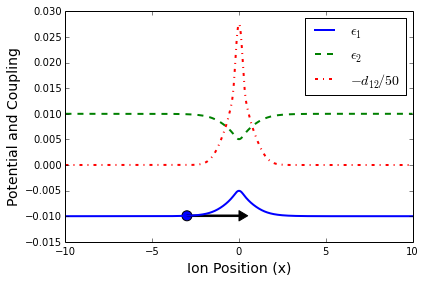

In [240]:
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.set_xlabel("Ion Position (x)",fontsize=14)
ax.set_ylabel("Potential and Coupling",fontsize=14)

ax.plot(xfine,e1(xfine),"-",lw=2,label="$\epsilon_1$")
ax.plot(xfine,e2(xfine),"--",lw=2,label="$\epsilon_2$")
ax.plot(xfine,-d12(xfine)/50.,"-.",lw=2,label="$-d_{12}/50$")
ax.scatter(-3,e1(-3),s=100)
ax.arrow(-3,e1(-3),3,0,head_width=0.002,head_length=0.5,
         color="black",width=0.0003)
ax.set_xlim(-10,10)

ax.legend(fontsize=14,loc="upper right")
fig.tight_layout()
plt.savefig("model-1-bosh.eps")

In [9]:
def run1(x0,v0,c1,nstep,dt=0.1,m=2000.):

    hbar = 1.0
    
    # initialize electronic state
    c2 = np.sqrt(1.-c1*c1)
    a11 = c1*np.conj(c1)
    a12 = c1*np.conj(c2)
    a21 = np.conj(a12)
    a22 = c2*np.conj(c2)

    # initialize ion
    pos = x0
    vel = v0

    # make room for scalar quantities
    pos_trace = np.zeros(nstep)
    vel_trace = np.zeros(nstep)
    a11_trace  = np.zeros(nstep)
    a22_trace  = np.zeros(nstep)
    energy_trace = np.zeros(nstep)
    pot_trace = np.zeros(nstep)
    prob_trace = np.zeros(nstep)

    on_surface1 = True
    surface = e1
    surface_der = e1der
    switch_prob = 0.0

    for t in range(nstep):

        # record scalar quantities
        pos_trace[t] = pos
        vel_trace[t] = vel
        pot_trace[t] = surface(pos)
        energy_trace[t] = 0.5*m*vel*vel + surface(pos)
        
        a11_trace[t] = a11.real
        a22_trace[t] = a22.real
        prob_trace[t] = switch_prob.real

        # propagate electronic state forward
        c1 += dt*(c1*e1(pos)/(1j*hbar) - c2*vel*d12(pos))
        c2 += dt*(c2*e2(pos)/(1j*hbar) + c1*vel*d12(pos))

        # find new electronic state and change rate
        a11 = c1*np.conj(c1)
        a12 = c1*np.conj(c2)
        a21 = np.conj(a12)
        a22 = c2*np.conj(c2)

        b12 = -2.*(np.conj(a12)*vel*d12(pos)).real
        b21 =  2.*(np.conj(a21)*vel*d12(pos)).real
        
        # calculate hop probability
        if on_surface1:
            switch_prob = dt*b21/a11
        else:
            switch_prob = dt*b12/a22
        # end if

        # decide hopping
        hopped = False
        if switch_prob.real > np.random.rand():
            
            new_kinetic = 0.0
            # check kinetic energy
            cur_energy = energy_trace[t]
            if on_surface1:
                new_kinetic = cur_energy - e2(pos)
            else:
                new_kinetic = cur_energy - e1(pos)
            # end if

            if new_kinetic < 0:
                hopped = False
            else:
                hopped = True
            # end if

            # switch surface if decide to hop
            if hopped:

                if on_surface1:
                    surface = e2
                    surface_der = e2der
                else:
                    surface = e1
                    surface_der = e1der
                # end if
                on_surface1 = not on_surface1

                # adjust velocity
                vel = np.sign(vel) * np.sqrt(2.*new_kinetic/m)

            # end if hopped

        # end if switch_prob > rand()

        # propagate ion forward
        a0 = -surface_der(pos)/m
        pos += vel*dt + 0.5*a0*dt*dt
        a1 = -surface_der(pos)/m
        vel += 0.5*(a0+a1)*dt
        
        if pos >= pos_max or pos <= pos_min:
            break
        # end if

    # end for t
    
    transmission = False
    reflection   = False
    if (pos >= pos_max):
        transmission = True
    # end if
    elif (pos <= pos_min):
        reflection = True
    # end if
    
    return pos_trace[:t],vel_trace[:t],pot_trace[:t],energy_trace[:t]\
,a11_trace[:t],a22_trace[:t],t\
,on_surface1,transmission,reflection,prob_trace[:t]
# end def 

In [15]:
dt = 1.0
nstep = 10000
ptrace,vtrace,pot_trace,energy_trace,a11_trace,a22_trace,t\
,on1,trans,ref,prob_trace = run1(-3.0,2.5/2000.,0.6,nstep,dt)

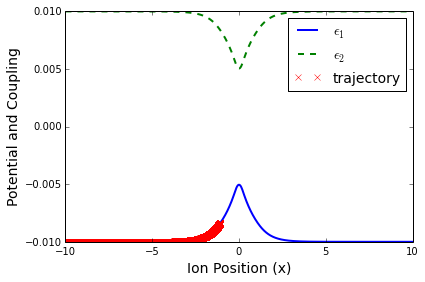

In [29]:
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.set_xlabel("Ion Position (x)",fontsize=14)
ax.set_ylabel("Potential and Coupling",fontsize=14)

ax.plot(xfine,e1(xfine),"-",lw=2,label="$\epsilon_1$")
ax.plot(xfine,e2(xfine),"--",lw=2,label="$\epsilon_2$")
#ax.plot(xfine,-d12(xfine)/50.,"-.",lw=2,label="$-d_{12}/50$")

ax.plot(ptrace,pot_trace,"x",label="trajectory")

ax.legend(fontsize=14,loc="upper right")
fig.tight_layout()
#plt.savefig("model-1-traj1.eps")

In [32]:
dt = 1.0
nstep = 10000
ptrace,vtrace,pot_trace,energy_trace,a11_trace,a22_trace,t\
,on1,trans,ref,prob_trace = run1(-3.0,5/2000.,0.6,nstep,dt)

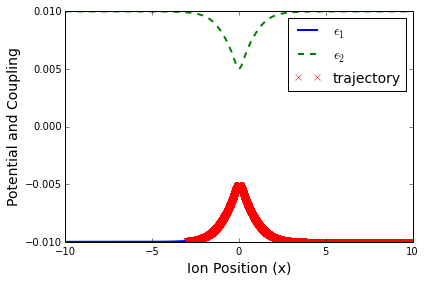

In [34]:
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.set_xlabel("Ion Position (x)",fontsize=14)
ax.set_ylabel("Potential and Coupling",fontsize=14)

ax.plot(xfine,e1(xfine),"-",lw=2,label="$\epsilon_1$")
ax.plot(xfine,e2(xfine),"--",lw=2,label="$\epsilon_2$")
#ax.plot(xfine,-d12(xfine)/50.,"-.",lw=2,label="$-d_{12}/50$")

ax.plot(ptrace,pot_trace,"x",label="trajectory")

ax.legend(fontsize=14,loc="upper right")
fig.tight_layout()
#plt.savefig("model-1-traj2.eps")

In [46]:
dt = 1.0
nstep = 10000
ptrace,vtrace,pot_trace,energy_trace,a11_trace,a22_trace,t\
,on1,trans,ref,prob_trace = run1(-3.0,25/2000.,0.6,nstep,dt)

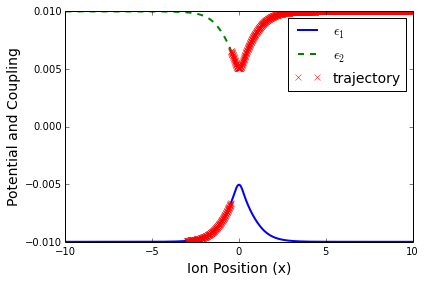

In [48]:
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.set_xlabel("Ion Position (x)",fontsize=14)
ax.set_ylabel("Potential and Coupling",fontsize=14)

ax.plot(xfine,e1(xfine),"-",lw=2,label="$\epsilon_1$")
ax.plot(xfine,e2(xfine),"--",lw=2,label="$\epsilon_2$")
#ax.plot(xfine,-d12(xfine)/50.,"-.",lw=2,label="$-d_{12}/50$")

ax.plot(ptrace,pot_trace,"x",label="trajectory")

ax.legend(fontsize=14,loc="upper right")
fig.tight_layout()
plt.savefig("model-1-traj3.eps")